In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1.1 Simulate 5 realizations

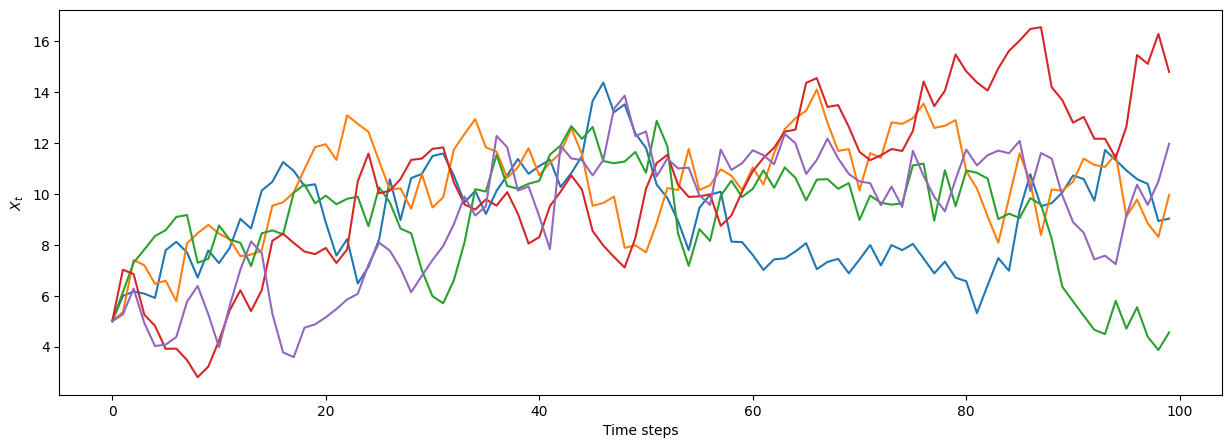

In [26]:
np.random.seed(42)
# Parameters
a = 0.9
b = 1
sigma1 = 1
X0 = 5
n = 100
num_realizations = 5

X = np.zeros((num_realizations, n))
X[:, 0] = X0

# Simulate the process
for t in range(1, n):
    noise = np.random.normal(0, sigma1, size=num_realizations)
    X[:, t] = a * X[:, t - 1] + b + noise

plt.figure(figsize=(15,5))
plt.plot(X.T)
plt.xlabel('Time steps')
plt.ylabel('$X_t$')
plt.show()

# 1.2 Simulate a single realization with observation noise

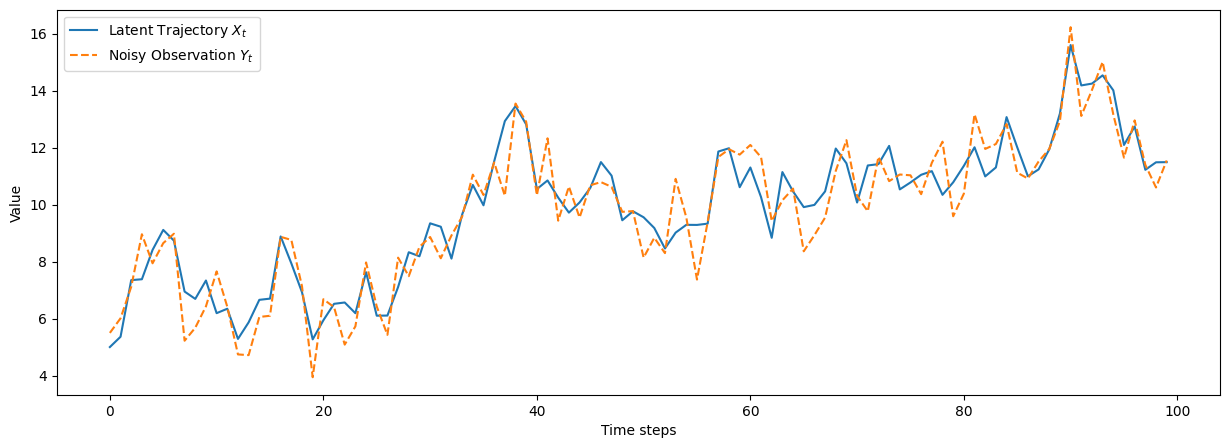

In [60]:
np.random.seed(42)
# Parameters
a = 0.9
b = 1
sigma1 = 1
X0 = 5
n = 100
num_realizations = 1

X = np.zeros((num_realizations, n))
X[:, 0] = X0
Y = np.zeros((num_realizations, n))
Y[:, 0] = X0 + np.random.normal(0, 1, size = num_realizations)

# Simulate the process
for t in range(1, n):
    noise = np.random.normal(0, sigma1, size=num_realizations)
    X[:, t] = a * X[:, t - 1] + b + noise
    obs_noise = np.random.normal(0, 1, size = num_realizations)
    Y[:, t] = X[:, t] + obs_noise

plt.figure(figsize=(15,5))
plt.plot(X.T, label = "Latent Trajectory $X_t$")
plt.plot(Y.T, label = "Noisy Observation $Y_t$", linestyle="--")
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.show()

# 1.3 Kalman filtering

In [10]:
def myKalmanFilter(y, theta, R, X0, P0):
    """
    Kalman filter for 1D state-space model:
        X_t+1 = a * X_t + b + ε1_t,   ε1_t ~ N(0, Q)
        Y_t = X_t + ε2_t,             ε2_t ~ N(0, R)

    Inputs:
    - y: array of observations (length T)
    - theta: tuple (a, b, Q) of system parameters
    - R: observation noise variance
    - X0: initial state estimate
    - P0: initial estimate variance

    Returns:
    - X_pred: predicted state means (length T)
    - P_pred: predicted state variances
    - innovations: Y_t - predicted Y_t
    - S: innovation variances
    - X_filt: filtered state means (posterior)
    - P_filt: filtered state variances (posterior)
    """
    a, b, Q = theta
    T = len(y)
    
    # Pre-allocate arrays
    X_pred = np.zeros(T)
    P_pred = np.zeros(T)
    innovations = np.zeros(T)
    S = np.zeros(T)
    X_filt = np.zeros(T)
    P_filt = np.zeros(T)
    
    # Initial values
    X_prev = X0
    P_prev = P0
    
    for t in range(T):
        # === Predict step ===
        X_pred[t] = a * X_prev + b
        P_pred[t] = a**2 * P_prev + Q
        
        # === Update step ===
        innovations[t] = y[t] - X_pred[t]         # Innovation: y_t - C * X_pred (C=1)
        S[t] = P_pred[t] + R                      # Innovation variance: C * P_pred * C^T + R (C=1)

        K = P_pred[t] / S[t]                      # Kalman gain

        X_filt[t] = X_pred[t] + K * innovations[t]   # Updated state estimate
        P_filt[t] = (1 - K) * P_pred[t]              # Updated estimate variance

        # Prepare for next step
        X_prev = X_filt[t]
        P_prev = P_filt[t]
    
    return X_pred, P_pred, innovations, S, X_filt, P_filt

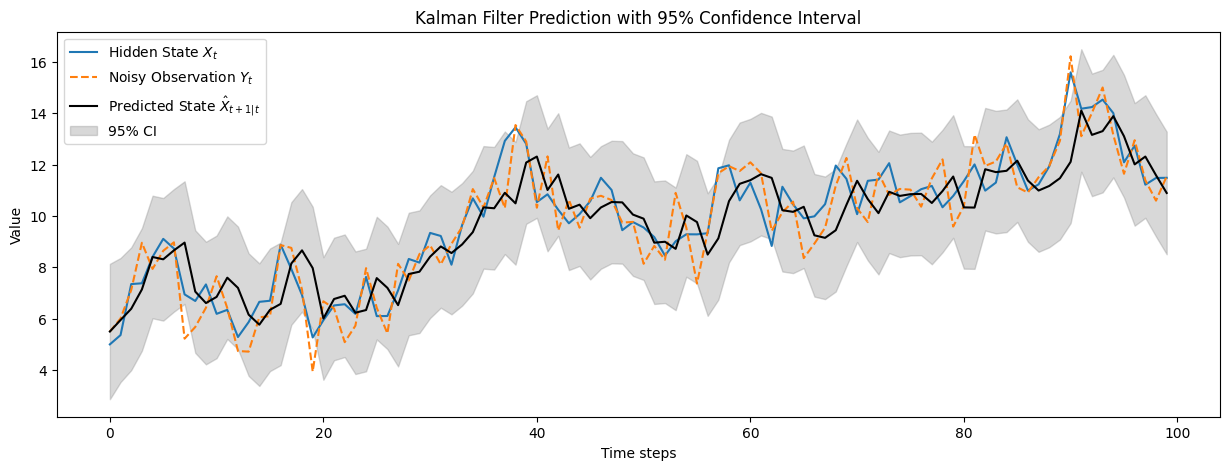

In [28]:

# Unpack Kalman filter output
X_pred, P_pred, innovations, S, X_filt, P_filt = myKalmanFilter(Y[0], (a, b, sigma1), 1, X0, 1)

# Compute 95% confidence interval (±1.96 * std)
lower_bound = X_pred - 1.96 * np.sqrt(P_pred)
upper_bound = X_pred + 1.96 * np.sqrt(P_pred)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(X.T, label="Hidden State $X_t$")
plt.plot(Y.T, label="Noisy Observation $Y_t$", linestyle="--")
plt.plot(X_pred, label=r"Predicted State $\hat{X}_{t+1|t}$", color="black")
plt.fill_between(np.arange(len(X_pred)), lower_bound, upper_bound, color='gray', alpha=0.3, label="95% CI")
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.title("Kalman Filter Prediction with 95% Confidence Interval")
plt.show()

In [29]:
def myLogLikFun(theta, y, R, x_prior=0, P_prior=10):
    # Unpack parameters
    a, b, sigma1 = theta
    Q = sigma1**2  # Process noise variance

    # Run Kalman filter
    X_pred, P_pred, innovations, S, X_filt, P_filt = myKalmanFilter(y, (a, b, Q), R, x_prior, P_prior)

    # Avoid log(0) or divide-by-zero issues
    S = np.clip(S, 1e-8, None)

    # Compute log-likelihood: sum over time steps of log N(y_t | X_pred, S)
    logL_terms = -0.5 * (np.log(2 * np.pi * S) + (innovations**2) / S)
    logL = np.sum(logL_terms)

    return -logL  # Negative log-likelihood for minimization

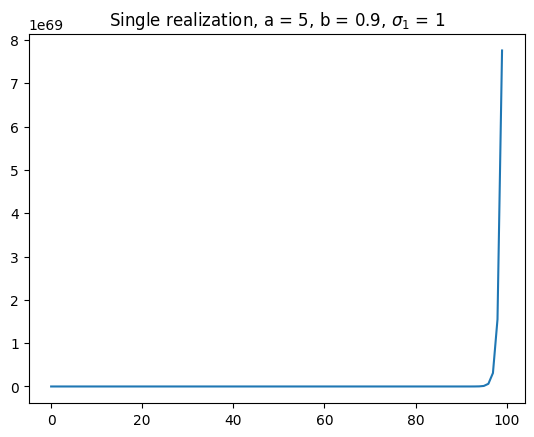

In [149]:
np.random.seed(42)
# Parameters
a = 5
b = 0.9
sigma1 = 1
X0 = 5
n = 100
num_realizations = 100

X = np.zeros((num_realizations, n))
X[:, 0] = X0
Y = np.zeros((num_realizations, n))
Y[:, 0] = X0 + np.random.normal(0, 1, size = num_realizations)

# Simulate the process
for t in range(1, n):
    noise = np.random.normal(0, sigma1, size=num_realizations)
    X[:, t] = a * X[:, t - 1] + b + noise
    obs_noise = np.random.normal(0, 1, size = num_realizations)
    Y[:, t] = X[:, t] + obs_noise

plt.plot(Y[0])
plt.title(f"Single realization, a = {a}, b = {b}, $\sigma_1$ = {sigma1}")
plt.show()

In [150]:
from scipy.optimize import minimize

# initial guess
theta0 = [1, 1, 1]

results = {'a':[],
           'b':[],
           'sigma':[]}

for real in Y:
    res = minimize(myLogLikFun, theta0, args=(real, 1), bounds=[(0.1, 10), (0.1, 10), (0.1, 10)])
    estimated_theta = res.x

    results['a'].append(estimated_theta[0])
    results['b'].append(estimated_theta[1])
    results['sigma'].append(estimated_theta[2])



a: 5.000, b: 1.000, sigma: 10.000


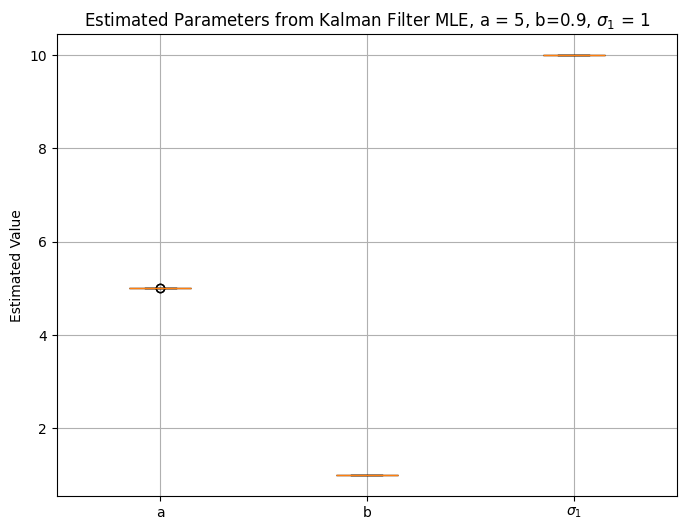

In [151]:
# Extract the results into a list of lists
data = [results['a'], results['b'], results['sigma']]

# Labels for the boxplot
labels = ['a', 'b', 'sigma']

# Plot
print(", ".join([f"{key}: {np.mean(val):.3f}" for key, val in zip(labels, data)]))
plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=['a', 'b', '$\sigma_1$'], patch_artist=True)
plt.title(f"Estimated Parameters from Kalman Filter MLE, a = {a}, b={b}, $\sigma_1$ = {sigma1}")
plt.ylabel("Estimated Value")
plt.grid(True)
plt.show()

# t-distribution

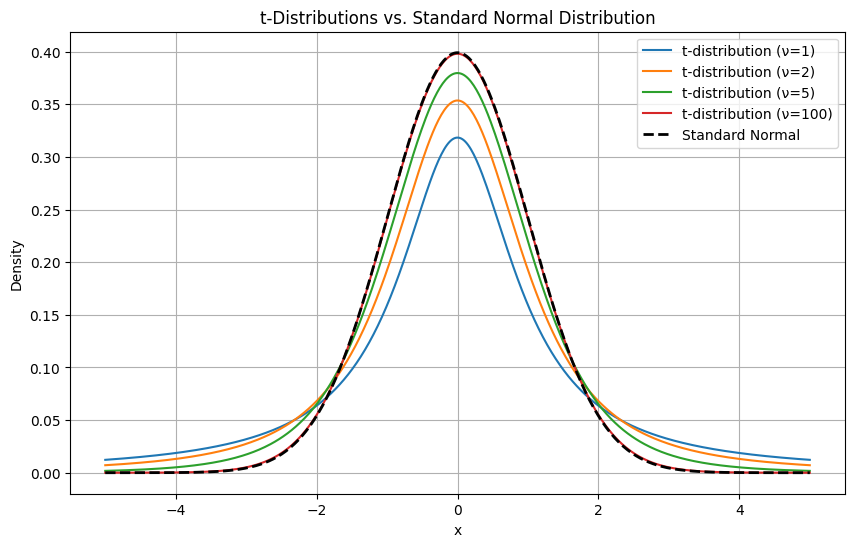

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Degrees of freedom for t-distribution
dfs = [1, 2, 5, 100]

# X values for plotting
x = np.linspace(-5, 5, 500)

# Plot
plt.figure(figsize=(10, 6))

# Plot t-distributions
for df in dfs:
    plt.plot(x, t.pdf(x, df), label=f"t-distribution (ν={df})")

# Plot standard normal
plt.plot(x, norm.pdf(x), 'k--', label="Standard Normal", linewidth=2)

# Formatting
plt.title("t-Distributions vs. Standard Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


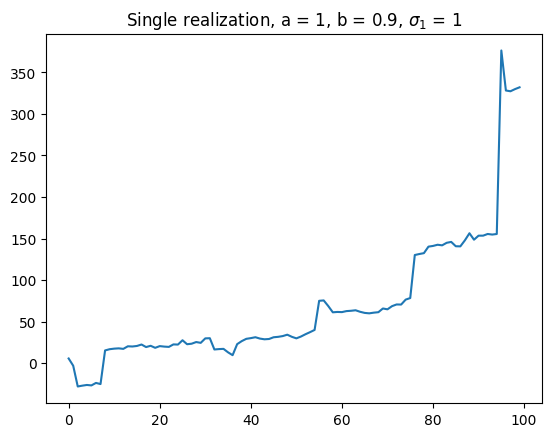

In [168]:
np.random.seed(42)
# Parameters
a = 1
b = 0.9
sigma1 = 1
X0 = 5
n = 100
num_realizations = 100
df = 1

X = np.zeros((num_realizations, n))
X[:, 0] = X0
Y = np.zeros((num_realizations, n))
Y[:, 0] = X0 + np.random.normal(0, 1, size = num_realizations)

# Simulate the process
for t in range(1, n):
    noise = np.random.standard_t(df, size=num_realizations)
    X[:, t] = a * X[:, t - 1] + b + noise
    obs_noise = np.random.normal(0, 1, size = num_realizations)
    Y[:, t] = X[:, t] + obs_noise

plt.plot(Y[0])
plt.title(f"Single realization, a = {a}, b = {b}, $\sigma_1$ = {sigma1}")
plt.show()

a: 0.976, b: 3.129, sigma: 7.815


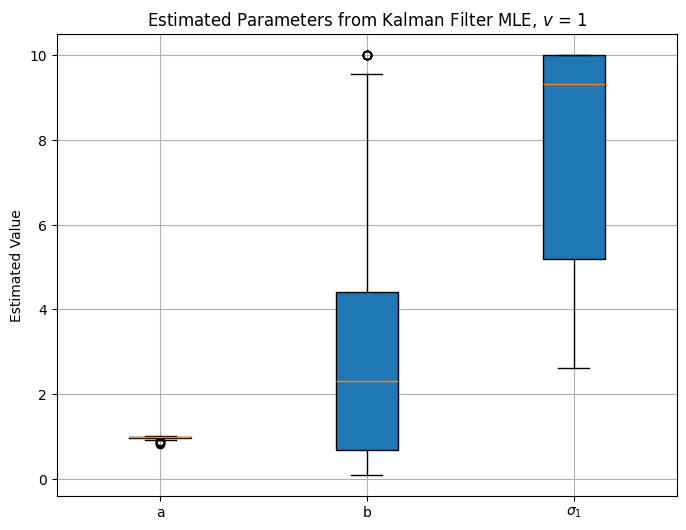

In [171]:

theta0 = [1, 1, 1]

results = {'a':[],
           'b':[],
           'sigma':[]}

for real in Y:
    res = minimize(myLogLikFun, theta0, args=(real, 1), bounds=[(0.1, 10), (0.1, 10), (0.1, 10)])
    estimated_theta = res.x

    results['a'].append(estimated_theta[0])
    results['b'].append(estimated_theta[1])
    results['sigma'].append(estimated_theta[2])


# Extract the results into a list of lists
data = [results['a'], results['b'], results['sigma']]

# Labels for the boxplot
labels = ['a', 'b', 'sigma']

# Plot
print(", ".join([f"{key}: {np.mean(val):.3f}" for key, val in zip(labels, data)]))
plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=['a', 'b', '$\sigma_1$'], patch_artist=True)
plt.title(f"Estimated Parameters from Kalman Filter MLE, $v$ = {df}")
plt.ylabel("Estimated Value")
plt.grid(True)
plt.show()